# Section 5.5 superposition in time.
# Simulating varying head at x=0 using a sequence of sudden changes of head at $x=0$ and $t=0$

IHE, Delft, 20120-01-06

@T.N.Olsthoorn

## Context

The aquifer is considered of constant transmissivity $kD$ and storage coefficient $S$ and to extend from $0 \le x \le \infty$.

The partial differential equation is

$$ kD \frac {\partial^2 s} {\partial x} = S \frac {\partial s} {\partial t}  $$

The solution for a sudden change of head equal to $A [m]$ at $x=0$ and $t = 0$ is

$$ s(x, t) = A \,\mathtt{erfc}(u), \,\,\,\, u=\sqrt{\frac {x^2 S} {4 kD t}} $$

where $\mathtt {erfc} () $ is the so-called complementary error function:

$$ \mathtt {erfc} (z) = \frac 2 {\sqrt {\pi} } \intop _z ^\infty e ^{-y^2}dy $$

And so its derivative is

$$ \frac {d \mathtt{erfc}(z)} {d z} = - \frac 2 {\sqrt {\pi}} e ^{-z^2} $$

Therefore, the discharge equals

$$ Q = -kD \frac {\partial s} {\partial x} = A \sqrt{\frac {kDS} {\pi t}} \mathtt{exp} \left( -u^2 \right) $$

and for $ x = 0 $

$$ Q_0 = A \sqrt{\frac {kD S} {\pi t}}$$

## Superposition

Any varying head can be approximated using a series of constant heads over short time intervals. This allows to use de 1D solution for a sudden head change to simulate the effect on an aquifer of a varying river head. It is assumed that the aquifer is in direct good contact with the surface water at $x=0$.

The superpostion may be written as

$$ s(x, t) = \sum _{i=1} ^{N} \left\{ A_i \mathtt{erfc} 
\sqrt{\frac {x^2 S} {4 kD (t - t_i)}} \right\}, \,\,\, t \ge t_i $$

Clearly, $a$ term $i$ is non-existent when $t < t_i$.

This formula can be computed by looping over the amplituces and times pertaining to each moment on which the amplitude changes.

With a series of amplitudues A, what matters is the change of amplitude. So we need

$$ A = A_0, A_1 - A_0, A_2 - A_1, ... A_n - A_{n-1} $$

## Loading modules

In [1]:
import numpy as np
from scipy.special import erfc
from matplotlib import pyplot as plt
from matplotlib import animation, rc
from matplotlib.animation import FuncAnimation
from matplotlib.patches import PathPatch, Path
from IPython.display import HTML
from scipy.special import erfc
import pdb

## Convenience function to set up a graph

In [2]:
def newfig(title='?', xlabel='?', ylabel='?', xlim=None, ylim=None,
                   xscale='linear', yscale='linear', size_inches=(14, 8), fontsize=15):
    '''Setup a new axis for plotting'''
    fig, ax = plt.subplots()
    fig.set_size_inches(size_inches)
    ax.set_title(title, fontsize=fontsize)
    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    if xlim is not None: ax.set_xlim(xlim)
    if ylim is not None: ax.set_ylim(ylim)
    ax.grid(True)
    return ax

## Implementation

A  =    1.5    0.5    1.0   -1.2    0.5   -1.8    0.3   -3.0    1.0    0.5   -0.3  [m]
dA =    1.5   -1.0    0.5   -2.2    1.7   -2.3    2.1   -3.3    4.0   -0.5   -0.8  [m]
tc =    1.5    1.8    6.3    8.6    8.9   12.3   22.3   22.5   23.7   29.3   29.9  [d]


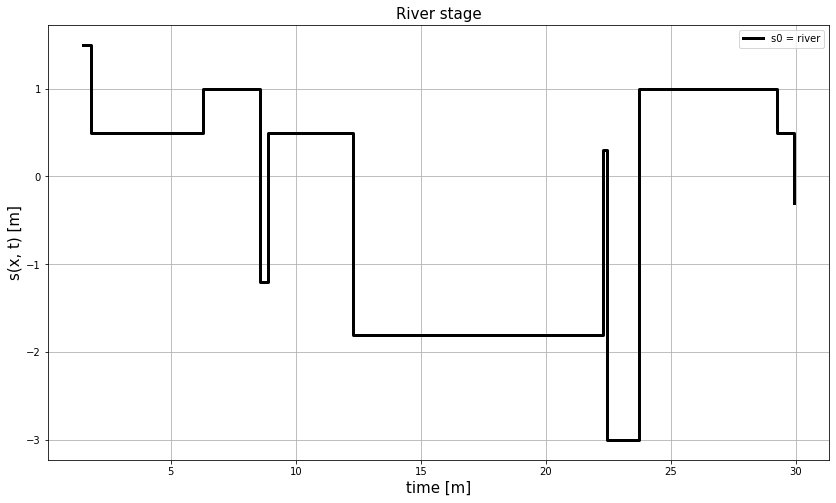

In [65]:
# aquifer properties
kD = 900 # m2/d
S = 0.1 # [-]

# A  is the water level at x=0 at the change times tc
A    = np.array([1.5, 0.5, 1.0, -1.2, 0.5, -1.8, 0.3, -3, 1, 0.5, -0.3]) # m
tend = 30
tc   = tend * np.random.rand(len(A)) # switch times
tc.sort()

dA   = np.diff(np.hstack((0, A))) # m, the head changes at x=0 at the change times

# show the switch times s0 and A
ax = newfig('River stage', 'time [m]', 's(x, t) [m]')

# this is an advanced way of neatly printed a line of formatted numbers
# making sure that the numbers in both lines are exactly above each other
# you could also just print(s0) and print(A)
print('A  = ' + ' '.join([f'{a:6.1f}' for a in A]) + '  [m]')
print('dA = ' + ' '.join([f'{dai:6.1f}' for dai in dA]) + '  [m]')
print('tc = ' + ' '.join([f'{tci:6.1f}' for tci in tc]) + '  [d]')
    

# plot the amplitudes and their changes
ax.step(tc, A, 'k', label="s0 = river", lw=3, where='post')
#ax.step(tc, A, label='dA = change', where='post')
ax.legend()


# Simulation by superposition in time

In [63]:
times = np.linspace(0, tend, 101) # simulatioin times in days
x = 150. # choose a value for x for which the graphs will be made
# plot heads
ax = newfig(f"Effect of varying river stage on groundwater at $x$={x:.0f}", 'time [d]',
            'head change relative to river stage [m]')
fig = ax.figure

lines = []
Y = np.zeros((len(dA) + 2, len(times)))

s = np.zeros_like(times)
for tci, Ai in zip(tc, A): # Switch times and jumps
    s[times > tci] = Ai
line, = ax.plot(times, s, 'b', lw=3, label="River level")
Y[0] = s
lines.append(line)

s = np.zeros_like(times)
for it, (tci, dAi) in enumerate(zip(tc, dA)): # Switch times and jumps
    u = np.sqrt((x**2 * S)/(4 * kD * (times[times > tci] - tci)))     
    ds = dAi * erfc(u)  # logical indexing
    Y[it + 1][times > tci] = ds
    line, = ax.plot(times[times > tci], ds, label=f'tc = {tci:.0f} d')
    lines.append(line)
    s[times > tci] += ds
line, = ax.plot(times, s, 'k', lw=3, label="Sum")
lines.append(line)
Y[-1] = line.get_ydata()

text = ax.text(0.25, 0.8, 't = {:5.2f}'.format(0), transform=ax.transAxes, fontsize=15, 
        bbox=dict(boxstyle='round', facecolor='gray', alpha=0.3))
ax.legend(loc='lower left')

def init():
    global lines, text
    for line in lines:
        line.set_data([], [])
    text.set_text('t = {:5.2f}'.format(0))
    return lines + [text]

def animate(it):
    global lines, times
    for y, line in zip(Y, lines):
        line.set_data(times[:it], y[:it])
    text.set_text('t = {:5.2f} d'.format(times[it]))
    return lines + [text]

# call the animator.  blit=True means only re-draw the parts that have changed.
print("Patience, computing and generating video takes about 30 sec. on mac...")
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(times), fargs=(),
                               interval=20, blit=True, repeat=False)

plt.close(anim._fig)
if False:
    out = HTML(anim.to_html5_video())
    out
else:
    anim.save('Sudden_changes_super_position_in_t.mp4', fps=20, extra_args=['-vcodec', 'libx264'])
    print(anim.save_count, " frames saved.")
    !ffmpeg -i Sudden_changes_super_position_in_t.mp4 -y Sudden_changes_super_position_in_t.gif
#out

Patience, computing and generating video takes about 30 sec. on mac...
101  frames saved.
ffmpeg version 3.2.1 Copyright (c) 2000-2016 the FFmpeg developers
  built with llvm-gcc 4.2.1 (LLVM build 2336.11.00)
  configuration: --prefix=/Volumes/Ramdisk/sw --enable-gpl --enable-pthreads --enable-version3 --enable-libspeex --enable-libvpx --disable-decoder=libvpx --enable-libmp3lame --enable-libtheora --enable-libvorbis --enable-libx264 --enable-avfilter --enable-libopencore_amrwb --enable-libopencore_amrnb --enable-filters --enable-libgsm --enable-libvidstab --enable-libx265 --disable-doc --arch=x86_64 --enable-runtime-cpudetect
  libavutil      55. 34.100 / 55. 34.100
  libavcodec     57. 64.101 / 57. 64.101
  libavformat    57. 56.100 / 57. 56.100
  libavdevice    57.  1.100 / 57.  1.100
  libavfilter     6. 65.100 /  6. 65.100
  libswscale      4.  2.100 /  4.  2.100
  libswresample   2.  3.100 /  2.  3.100
  libpostproc    54.  1.100 / 54.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, fr

In [64]:
pwd

'/Users/Theo/Instituten-Groepen-Overleggen/IHE/git/TransientGroundwaterFlow/excercises_notebooks'

## The discharge at $x=0$

The implementation of the discharge at $x=0$ is straightforward given the mathematical expression derived above.

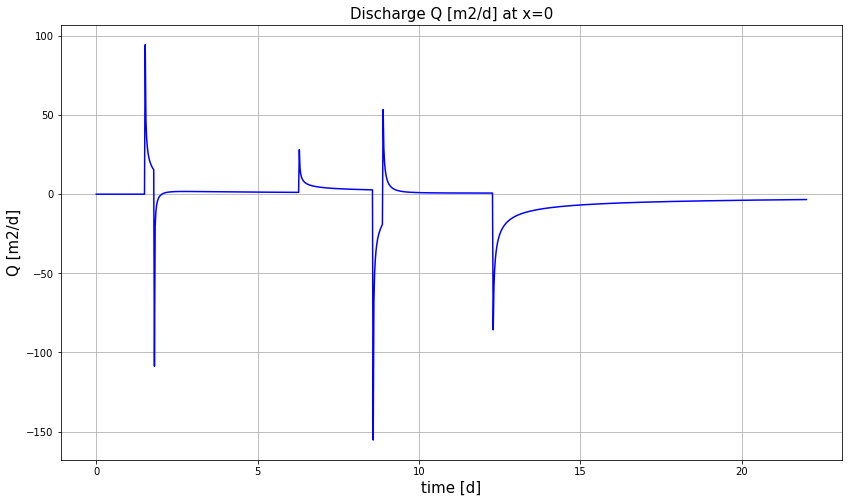

In [66]:
t = np.linspace(0, 2 * len(tc), 1001.) # more points for more detail
ax = newfig('Discharge Q [m2/d] at x=0', 'time [d]','Q [m2/d]')

Q0 = np.zeros_like(t) # initialize the discharge as zeroes

for tci, dAi in zip(tc, dA):
    Q0[t > tci] += dAi * np.sqrt(kD * S / (np.pi * (t[t > tci] - tci)) )

ax.plot(t, Q0, 'b', label='Q0')


In [74]:
from scipy.special import exp1
exp1(5)

0.0011482955912753257